In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import bokeh
from bokeh.layouts import Row, column, gridplot
from bokeh.models import Title, Legend, TapTool, Range1d, TabPanel, Tabs
import matplotlib as mpl

from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import Span


In [2]:
color_palette = [  '#4E79A7',  # Blue
    '#F28E2B',  # Orange
    '#E15759',  # Red
    '#76B7B2',  # Teal
    '#59A14F',  # Green
    '#EDC948',  # Yellow
    '#B07AA1',  # Purple
    '#FF9DA7',  # Pink
    '#9C755F',  # Brown
    '#BAB0AC',  # Gray
    '#7C7C7C',  # Dark gray
    '#6B4C9A',  # Violet
    '#D55E00',  # Orange-red
    '#CC61B0',  # Magenta
    '#0072B2',  # Bright blue
    '#329262',  # Peacock green
    '#9E5B5A',  # Brick red
    '#636363',  # Medium gray
    '#CD9C00',  # Gold
    '#5D69B1',  # Medium blue
]

In [3]:
from shapely.geometry import Point

def convert_to_gdf(df):
    geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

    return gdf

In [7]:
syria_adm3 = gpd.read_file('../../data/shapefiles/syr_pplp_adm4_unocha_20210113/syr_admbnda_adm3_uncs_unocha_20201217.json')
syria_adm4 = gpd.read_file('../../data/shapefiles/syr_pplp_adm4_unocha_20210113/syr_pplp_adm4_unocha_20210113.json')
region_control = pd.read_excel('../../data/shapefiles/IntensityAoC_ADM4_v12.xlsx')
intensity = pd.read_csv('../../data/earthquake-intensity/syria_adm4_earthquake_intensity.csv')

region_control = region_control[['ADM4_EN', 'Population', 'aoc']]
syria_adm4 = syria_adm4.merge(region_control, on = ['ADM4_EN'])

In [15]:
from datetime import datetime

acled = pd.read_csv('../../data/acled/2020-01-01-2023-04-06-Syria.csv')
#acled['timestamp'] = acled['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
acled['event_date'] = acled['event_date'].apply(lambda x: datetime.strptime(x, '%d %B %Y'))

In [16]:
acled = convert_to_gdf(acled)
syria_adm4_crs = syria_adm4.to_crs('EPSG:32632')
acled_crs = acled.to_crs('EPSG:32632')

In [18]:
acled_adm4 = syria_adm4_crs.sjoin_nearest(acled_crs, max_distance=489.994)
acled_adm4 = acled_adm4.groupby(['ADM1_EN', 'ADM2_EN', 'ADM3_EN', 'ADM4_EN', 'aoc',pd.Grouper(key='event_date', freq='D')]).sum('fatalities')[['fatalities']].reset_index()

#acled_event = syria_adm4_crs.sjoin_nearest(acled_crs, max_distance=489.994)
acled_event = acled.groupby(['event_type', pd.Grouper(key='event_date', freq='M')]).sum('fatalities')[['fatalities']].reset_index()

,ADM1_EN,ADM2_EN,ADM3_EN,ADM4_EN,max_intensity_feb06,mean_feb20
0,Al-Hasakeh,Al-Hasakeh,Be'r Al-Hulo Al-Wardeyyeh,A'Kar,5.0,0.0
1,Al-Hasakeh,Al-Hasakeh,Tal Tamer,A'Sforiyeh,5.2,0.0
2,Aleppo,Al Bab,A'rima,A'rima,6.0,0.0
3,Aleppo,Al Bab,Al Bab,Aabad,6.0,0.0
4,Aleppo,Jebel Saman,Tall Ed-daman,Aabad,5.8,4.0
...,...,...,...,...,...,...
7589,Lattakia,Al-Haffa,Kansaba,Zweiaqat,5.6,4.2
7590,Tartous,Safita,Safita,Zweiteini,5.2,0.0
7591,Homs,Tall Kalakh,Nasra,Zweitiniyeh,4.8,0.0
7592,Aleppo,Jebel Saman,Zarbah,Zyare Semaan,6.6,4.6


In [24]:
acled_adm4 = acled_adm4.merge(intensity[['ADM1_EN', 'ADM2_EN','ADM3_EN', 'ADM4_EN', 'max_intensity_feb06', 'mean_feb20']], how ='right', on = ['ADM1_EN', 'ADM2_EN', 'ADM3_EN', 'ADM4_EN'])

In [25]:
acled_adm4.to_csv('../../data/acled/acled_admin4_2020_2023.csv')

In [34]:
acled_aoc = acled_adm4.groupby(['aoc', pd.Grouper(key='event_date', freq='M')]).sum('fatalities').reset_index()

In [43]:
bokeh.core.validation.silence(EMPTY_LAYOUT, True)

def get_line_plot(ooklaUsers,title, source, earthquakes=False, subtitle=None, measure = 'percent_change', category = 'aoc'):

    p2 = figure(x_axis_type = 'datetime', width = 1000, height = 400, toolbar_location='above')
    p2.add_layout(Legend(), "right")

    for id, adm2 in enumerate(ooklaUsers[category].unique()):
        df = ooklaUsers[ooklaUsers[category]==adm2][['event_date', 'fatalities']].reset_index(drop=True)
        p2.line(df['event_date'], df['fatalities'], line_width=2, line_color = color_palette[id], legend_label=adm2)

    p2.legend.click_policy='hide'
    if subtitle is not None:
        p2.title = subtitle


    title_fig = figure(title=title, toolbar_location=None,width=800, height=40, )
    title_fig.title.align = "left"
    title_fig.title.text_font_size = "20pt"
    title_fig.border_fill_alpha = 0
    title_fig.outline_line_width=0

    #with silence(MISSING_RENDERERS):
    sub_title = figure(title=source, toolbar_location=None,width=800, height=40, )
    sub_title.title.align = "left"
    sub_title.title.text_font_size = "10pt"
    sub_title.title.text_font_style="normal"
    sub_title.border_fill_alpha = 0
    sub_title.outline_line_width=0

    layout = column(title_fig, p2, sub_title)

    if earthquakes:
        p2.renderers.extend([
        Span(
            location=datetime(2023, 2, 6),
            dimension="height",
            line_color='#7C7C7C',
            line_width=2,
            line_dash=(4,4)
      ),
        Span(
            location=datetime(2023, 2, 20),
            dimension="height",
            line_color='#7C7C7C',
            line_width=2,
            line_dash=(4,4)
        ),
    ]
)

    return layout

# Armed Conflict Location and Event Data

This is a crowdsourced dataset that records all the conflicts occuring in a particular region. Access to this dataset is obtained through a partnership between the World Bank and ACLED. 

,aoc,event_date,fatalities
24,Contested Areas,2022-01-31,2
25,Contested Areas,2022-02-28,0
26,Contested Areas,2022-03-31,0
27,Contested Areas,2022-04-30,0
28,Contested Areas,2022-05-31,24
...,...,...,...
229,Turkish Armed Forces and National Army (opposi...,2022-11-30,50
230,Turkish Armed Forces and National Army (opposi...,2022-12-31,52
231,Turkish Armed Forces and National Army (opposi...,2023-01-31,72
232,Turkish Armed Forces and National Army (opposi...,2023-02-28,19


In [47]:
output_notebook()
title = 'Monthly conflict related fatalities by Area of Control'
source= 'ACLED'

show(get_line_plot(acled_aoc[acled_aoc['event_date'].dt.year>2021], title = title, source= source, category='aoc'))

Loading BokehJS ...

In [45]:
title = 'Monthly conflict by type of event'

show(get_line_plot(acled_event, category='event_type', title=title, source=source))

In [38]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def get_fig(acled, start_date = None, end_date=None, title=None):

    fig, ax = plt.subplots(figsize=(12,6))
    plt.rcParams["font.family"] = "Arial"

    if start_date is not None:
        df = acled[(acled['event_date']>start_date)&(acled['event_date']<end_date)]
    else:
        df = acled
    
    vmin = 0
    vmax = 70

    #syria_adm3.boundary.plot(ax=ax, color = '#d3d3d3')
    p1 = df.plot(column='fatalities', cmap = 'Reds', ax=ax, vmin=vmin, vmax=vmax)
    #turkey_adm2.boundary.plot(ax=ax, edgecolor = '#D3D3D3', linewidth=0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])

    if title is not None:
        ax.set_title(title)



    sm = plt.cm.ScalarMappable(cmap='Reds',norm=plt.Normalize(vmin=vmin, vmax=vmax))


    divider = make_axes_locatable(ax)
    dvider_kwargs = dict(position="left", size="1.5%", pad=0)
    fig.colorbar(sm, cax=divider.append_axes(**dvider_kwargs),
                #format = matplotlib.ticker.FuncFormatter(lambda x, pos: ''),
                #ticks = matplotlib.ticker.FixedLocator([])
                )

    return p1

<Axes: title={'center': 'Fatalities between 5th February 2023 and 31st March 2023'}>

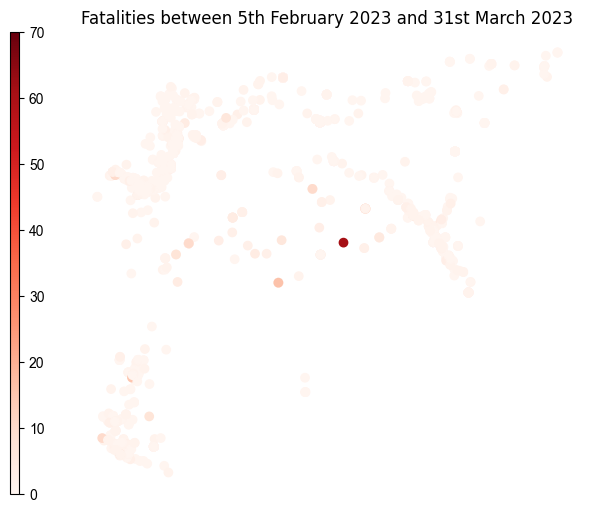

In [39]:
get_fig(acled, '2023-02-05', '2023-03-31', 'Fatalities between 5th February 2023 and 31st March 2023')

<Axes: title={'center': 'Fatalities between 5th February 2022 and 31st March 2022'}>

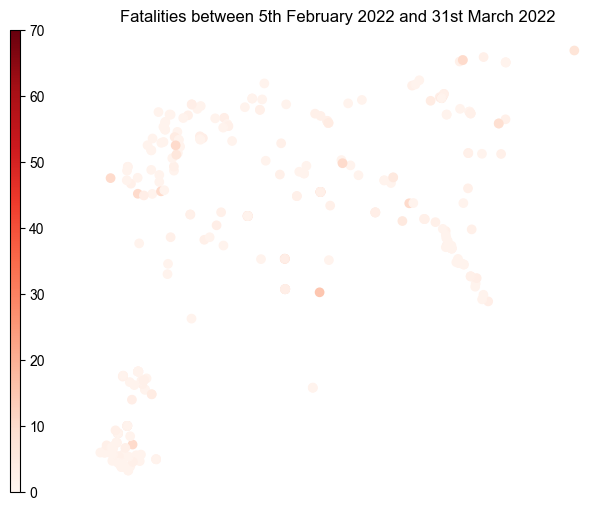

In [186]:
get_fig(acled, '2022-02-05', '2022-03-31', 'Fatalities between 5th February 2022 and 31st March 2022')